In [95]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from keras.preprocessing import image

import matplotlib.pyplot as plt
%matplotlib inline

import models.simpleConv as simpleConv
from imgaug import augmenters as iaa

import h5py


dataPath = 'RealImageNet/ImageNetSubsample/Data/CLS-LOC'
trainPath = os.path.join(dataPath, 'train')
# fiveTrain = os.path.join(dataPath, 'fiveTrain')
# testPath = os.path.join(dataPath, 'test')
# validationPath = os.path.join(dataPath, 'val')

# trainPath = fiveTrain

img_width, img_height = 224, 224

In [96]:
def parseData(saveFile = None):
    x_train = []
    x_train_aug = []
    y_train_aug = []
    y_train = []
    filePaths = []
    trainingFolders = [x for x in os.listdir(trainPath)]

    lines = [line.rstrip('\n').split() for line in open('RealImageNet/LOC_synset_mapping.txt')]
    wnids_to_words = {line[0]:' '.join(line[1:]) for line in lines }

    train_bboxes = {} #{image_name: list(bboxes)}
    for id in trainingFolders:
        boxesPath = os.path.join("RealImageNet", "LOC_train_solution.csv")
        lines = [line.rstrip('\n').split(',') for line in open(boxesPath)][1:]
        for line in lines:
            imageId = line[0]
            predictionString = line[1]
            split = predictionString.split()
            train_bboxes[imageId] = []
            for i in range(0, len(split), 5):
                box = split[i:i+5]
                train_bboxes[imageId].append(box)

    for imageName in train_bboxes.keys():
        imageLabel = imageName.split('_')[0]
        imagePath = os.path.join(trainPath, imageLabel, imageName + ".JPEG") #folder name

        if os.path.exists(imagePath):
            img = image.load_img(imagePath, target_size=(224, 224)) #pil format
            x = image.img_to_array(img)/255.
    #         x = np.expand_dims(x, axis=0) # making a numpy array (surrounds with another lis)
    #         x_train.append(x/255.)
            for box in train_bboxes[imageName]:
                x_train.append(x)
                idk = [imageLabel[1:]]
                y_train.append(idk)
#                 filePaths.append(imageName)



                augers = [iaa.GaussianBlur(3.0), iaa.Fliplr(1.0), iaa.Invert(0.05, per_channel=True)]

                for auger in augers:
                    aug = auger.augment_image(x)
                    x_train_aug.append(aug)
                    y_train_aug.append(idk)



    addAugment = True

    x_train = np.array(x_train)
    x_train_aug = np.array(x_train_aug)
    # x_train = np.expand_dims(x_train, axis= 1)
    y_train = np.array(y_train, dtype = 'uint')
    y_train_aug = np.array(y_train_aug, dtype='uint')
    # y_train = np.expand_dims(y_train, axis= 0)
    filePaths = np.array(filePaths)
    
    if saveFile: # if not None
        output = h5py.File(saveFile, 'w') 
        output.create_dataset('x_train', data = x_train) 
        output.create_dataset('y_train', data = y_train) 
#         output.create_dataset('x_train_aug', data = x_train_aug) 
#         output.create_dataset('y_train_aug', data = y_train_aug) 
#         output.create_dataset('filePaths', data = filePaths) 
        output.close()
    return x_train, x_train_aug, y_train, y_train_aug, filePaths

In [112]:
# from keras.preprocessing import image
# get training data

parse = False

if parse:
    x_train, x_train_aug, y_train, y_train_aug, filePaths = parseData('savedParsing.h5')
else:
    input_data = h5py.File('savedParsing.h5', 'r') 
    x_train = input_data['x_train'][:] 
    y_train = input_data['y_train'][:] 
#     x_train_aug = input_data['x_train_aug'][:] 
#     y_train_aug = input_data['y_train_aug'][:]
#     filePaths = input_data['filePaths'][:] 
    input_data.close()

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

label_encoder = LabelBinarizer()
y_train = label_encoder.fit_transform(y_train)
y_train_aug = label_encoder.fit_transform(y_train_aug)


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)


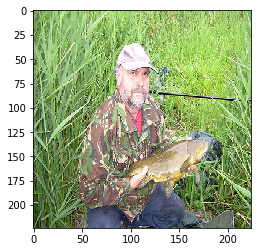

In [83]:

x=x_train[0]
x=x_train_aug[11]
plt.imshow(x)

# aug = augs[1].augment_image(x)
# plt.imshow(aug)

In [98]:
# x_train = x_train_aug
# y_train = y_train_aug

model = simpleConv.build_model(img_width, img_height, 3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

results = model.fit(x_train, y_train, epochs=1, verbose=1)

Epoch 1/1
2358/2358 [==============================] - 199s 85ms/step - loss: 1.0366 - acc: 0.5348


# 4. Testing & Post-Processing (Metrics, Graphs, etc.)

## Plot Training Results

KeyError: 'val_acc'

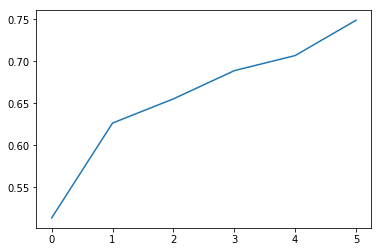

In [19]:
# Plot training & validation accuracy values
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
# plt.ylim(0.5, 1.0)
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
# plt.ylim(0, 0.7)
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
predictedModel = model.predict(x_val)
predictedModel2 = model.predict(x_train)



predLabel1 = [wnids_to_words['n0' + str(int(x))] for x in label_encoder.inverse_transform(predictedModel)]

# trueLabel1 = [wnids_to_words['n0' + str(int(x))] for x in label_encoder.inverse_transform(y_val)]

# predLabel2 = [wnids_to_words['n0' + str(int(x))] for x in label_encoder.inverse_transform(predictedModel2)]

# trueLabel2 = [wnids_to_words['n0' + str(int(x))] for x in label_encoder.inverse_transform(y_train)]



# import pandas as pd
# from sklearn.metrics import accuracy_score

# dataframe = pd.DataFrame({'pred': predLabel1, 'true': trueLabel1})

# dataframe2 = pd.DataFrame({'pred': predLabel2, 'true': trueLabel2})

# print("Validation Accuracy = {0}".format(accuracy_score(dataframe.pred, dataframe.true)))
# print("Training Accuracy = {0}".format(accuracy_score(dataframe2.pred, dataframe2.true)))


In [111]:
dataframe[dataframe.pred != dataframe.true]

,pred,true
1,"great white shark, white shark, man-eater, man...","hammerhead, hammerhead shark"
6,"hammerhead, hammerhead shark","great white shark, white shark, man-eater, man..."
8,"tiger shark, Galeocerdo cuvieri","great white shark, white shark, man-eater, man..."
9,"hammerhead, hammerhead shark","tiger shark, Galeocerdo cuvieri"
10,"hammerhead, hammerhead shark","great white shark, white shark, man-eater, man..."
11,"hammerhead, hammerhead shark","great white shark, white shark, man-eater, man..."
14,"hammerhead, hammerhead shark","tiger shark, Galeocerdo cuvieri"
17,"tench, Tinca tinca","goldfish, Carassius auratus"
20,"hammerhead, hammerhead shark","tiger shark, Galeocerdo cuvieri"
22,"hammerhead, hammerhead shark","tiger shark, Galeocerdo cuvieri"


In [109]:
label_encoder.inverse_transform(predictedModel).info

AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [100]:
trueLabel2

[1491361,
 1443537,
 1484850,
 1494475,
 1484850,
 1443537,
 1440764,
 1491361,
 1494475,
 1491361,
 1440764,
 1491361,
 1491361,
 1440764,
 1494475,
 1491361,
 1440764,
 1443537,
 1484850,
 1494475,
 1491361,
 1440764,
 1443537,
 1484850,
 1440764,
 1443537,
 1491361,
 1443537,
 1484850,
 1443537,
 1491361,
 1440764,
 1491361,
 1443537,
 1443537,
 1484850,
 1484850,
 1443537,
 1443537,
 1491361,
 1443537,
 1443537,
 1443537,
 1443537,
 1443537,
 1440764,
 1494475,
 1491361,
 1440764,
 1443537,
 1443537,
 1443537,
 1494475,
 1491361,
 1443537,
 1484850,
 1440764,
 1491361,
 1494475,
 1440764,
 1443537,
 1494475,
 1443537,
 1491361,
 1494475,
 1440764,
 1440764,
 1484850,
 1443537,
 1494475,
 1440764,
 1491361,
 1484850,
 1491361,
 1440764,
 1440764,
 1491361,
 1440764,
 1443537,
 1494475,
 1440764,
 1443537,
 1491361,
 1491361,
 1443537,
 1440764,
 1491361,
 1491361,
 1440764,
 1484850,
 1491361,
 1484850,
 1491361,
 1484850,
 1443537,
 1491361,
 1484850,
 1484850,
 1491361,
 1491361,


In [46]:
predictedModel2.shape

(2358, 5)

In [39]:
dataframe2

,pred,true
0,1440764,1440764
1,1440764,1440764
2,1440764,1440764
3,1440764,1440764
4,1440764,1440764
5,1440764,1440764
6,1440764,1440764
7,1440764,1440764
8,1440764,1440764
9,1440764,1440764


In [22]:
predLabel1

['great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tench, Tinca tinca',
 'tiger shark, Galeocerdo cuvieri',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'tiger shark, Galeocerdo cuvieri',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'goldfish, Carassius auratus',
 'goldfish, Carassius auratus',
 'tiger shark, Galeocerdo cuvieri',
 'great white shark, white shark, man-eater, man-eati

In [23]:
predLabel2

['tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 '

In [24]:
trueLabel2

['tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Ti

In [42]:
trueLabel1

AttributeError: 'list' object has no attribute 'shape'